This workbook begins using the environment we have setup on Azure Machine Learning to iterate through several multilayer perceptrons.

In [ ]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard

In [124]:
%load_ext autoreload
%autoreload 2

In [186]:
from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook, and setup for these expirments

In [2]:
# Load the stored workspace
ws = Workspace.from_config()

In [3]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [4]:
from azureml.core.environment import Environment
#from azureml.core.conda_dependencies import CondaDependencies

# get the registered env
env = Environment.get(ws, 'waste-env')

In [5]:
# get our compoute cluster
compute_name = "cpu-cluster-ds12"
compute_target = ws.compute_targets[compute_name]

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [6]:
%%writefile train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')
parser.add_argument('--nodes', 
                    type=str, 
                    dest='nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--activations', 
                    type=str, 
                    dest='activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')
parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
activations = args.activations.split(',')
nodes = args.nodes.split(',')

# get azure run context
run = Run.get_context()

# print to log for debuggig if necessary
print('Data folder:',args.data_path)
print('Activations:', activations)
print('Nodes:', nodes)

# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             batch_size = num_train)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             batch_size = num_test)


# import all images because MLP will not accept generator batches
train_imgs, train_labels = next(train_generator)
val_imgs, val_labels = next(val_generator)
test_imgs, test_labels = next(test_generator)


# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]

# Build the model
model = models.Sequential()
model.add(layers.Flatten())

# create hidden layers based on parameters
for node, activation in zip(nodes, activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
history = model.fit(x=train_imgs, y=train_labels, epochs=args.epochs,
                    validation_data=(val_imgs, val_labels),
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_imgs, test_labels)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting train.py


In [7]:
# move the file to the upload dir
shutil.copy('train.py', 'train_script/')
shutil.copy('utils.py', 'train_script/')


'train_script/utils.py'

## Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [8]:
# set the expiriment
experiment_name = 'mlp'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [9]:
# create var to stor run objects
runs = []

### Model 1
- hidden layer 1: 32 nodes, sigmoid activation function
- hidden layer 2: 16 nodes, sigmoid activation function
- optimizer: sgd

In [10]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [11]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'sigmoid-sgd'})

runs[-1].tag('activation', 'sigmoid')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '2')

### Model 2
- hidden layer 1: 32 nodes, relu activation function
- hidden layer 2: 16 nodes, relu activation function
- optimizer: sgd

In [12]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'relu,relu',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [13]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'relu-sgd'})

runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615656470_ffdc4734,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


### Model 3
- hidden layer 1: 32 nodes, sigmoid activation function
- hidden layer 2: 16 nodes, sigmoid activation function
- optimizer: adam

In [14]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'adam',
        '--epochs', 50,]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [15]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name':'sigmoid-adam'})

runs[-1].tag('activation', 'sigmoid')
runs[-1].tag('optimizer', 'adam')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615656474_a157ccc3,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


### Model 4
- hidden layer 1: 32 nodes, relu activation function
- hidden layer 2: 16 nodes, relu activation function
- optimizer: adam

In [16]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '32,16',
        '--activation', 'relu,relu',
        '--optimizer', 'adam',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [17]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name':'relu-adam'})

runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'adam')
runs[-1].tag('hidden layers', '2')

runs[-1]

Experiment,Id,Type,Status,Details Page,Docs Page
mlp,mlp_1615656477_520a50bc,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [18]:
runs

[Run(Experiment: mlp,
 Id: mlp_1615656464_eb63f1c0,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: mlp,
 Id: mlp_1615656470_ffdc4734,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: mlp,
 Id: mlp_1615656474_a157ccc3,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: mlp,
 Id: mlp_1615656477_520a50bc,
 Type: azureml.scriptrun,
 Status: Preparing)]

### Start Tensorboard to monitor the runs

In [19]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [259]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [242]:
log = log_runs(runs, 'mlp')
log

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
id,,,,,,,,
mlp_1615656464_eb63f1c0,sigmoid-sgd,mlp,1.463566,0.467742,"[1.7974865436553955, 1.7372865676879883, 1.713...","[0.1729753464460373, 0.2315140813589096, 0.277...","[1.7528793811798096, 1.7180869579315186, 1.692...","[0.17557251453399658, 0.3358778655529022, 0.30..."
mlp_1615656470_ffdc4734,relu-sgd,mlp,1.716608,0.233871,"[2.2597947120666504, 1.7758759260177612, 1.767...","[0.21478873491287231, 0.23503521084785461, 0.2...","[1.7806367874145508, 1.7706297636032104, 1.762...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656474_a157ccc3,sigmoid-adam,mlp,1.716935,0.233871,"[1.770506501197815, 1.726367712020874, 1.72556...","[0.20246478915214539, 0.23503521084785461, 0.2...","[1.7273155450820923, 1.7236706018447876, 1.722...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656477_520a50bc,relu-adam,mlp,1.753966,0.225806,"[12.43702507019043, 2.7881507873535156, 1.8240...","[0.1672535240650177, 0.16109155118465424, 0.20...","[2.6074233055114746, 1.9728984832763672, 1.739...","[0.16030533611774445, 0.18320611119270325, 0.1..."


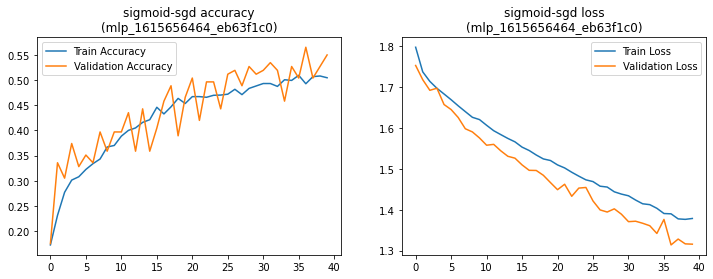

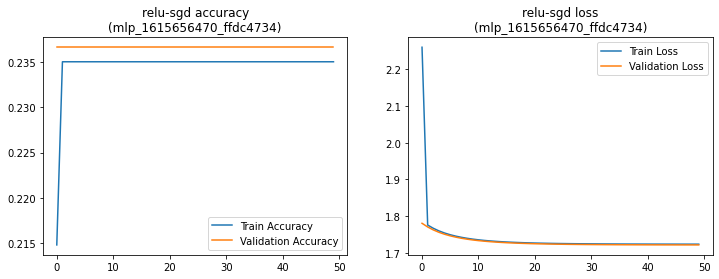

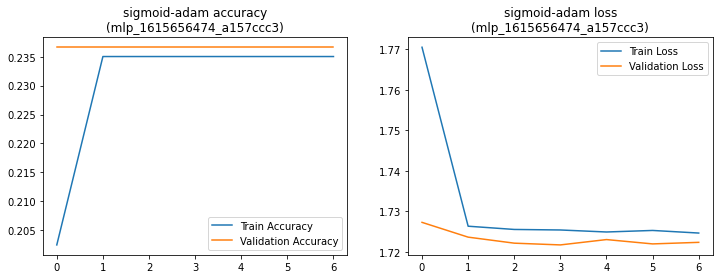

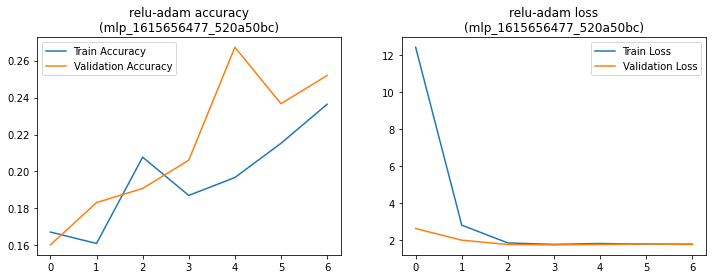

In [158]:
visualize_log(log)

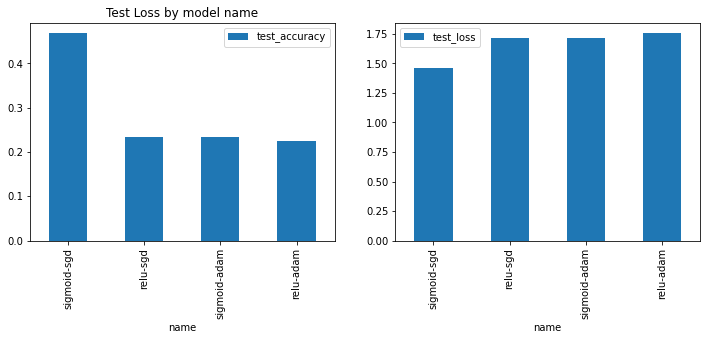

In [185]:
plot_accuracy(log)

Talk about runs here.

### Model 5

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 64 nodes, sigmoid activation function
- hidden layer 2: 32 nodes, sigmoid activation function
- optimizer: sgd

In [39]:
# Start with our best run for comparison
runs2 = [runs[0]]

In [40]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '64,32',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [41]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': '64-32'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '64,32')

### Model 6

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 128 nodes, sigmoid activation function
- hidden layer 2: 64 nodes, sigmoid activation function
- optimizer: sgd

In [42]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '128,64',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [43]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': '128-64'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '128,64')

### Model 7

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 256 nodes, sigmoid activation function
- hidden layer 2: 128 nodes, sigmoid activation function
- optimizer: sgd

In [44]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '256,128',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [45]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': '256-128'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '256,128')

### Model 8

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 512 nodes, sigmoid activation function
- hidden layer 2: 256 nodes, sigmoid activation function
- optimizer: sgd

In [46]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '512,256',
        '--activation', 'sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [47]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': '512-256'})

runs2[-1].tag('activation', 'sigmoid')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '2')
runs2[-1].tag('layer sizes', '512,256')

### Start Tensorboard to monitor the runs

In [48]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs2)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [49]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [245]:
log = log_runs(runs2, 'mlp')
log

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
id,,,,,,,,
mlp_1615656464_eb63f1c0,sigmoid-sgd,mlp,1.463566,0.467742,"[1.7974865436553955, 1.7372865676879883, 1.713...","[0.1729753464460373, 0.2315140813589096, 0.277...","[1.7528793811798096, 1.7180869579315186, 1.692...","[0.17557251453399658, 0.3358778655529022, 0.30..."
mlp_1615656470_ffdc4734,relu-sgd,mlp,1.716608,0.233871,"[2.2597947120666504, 1.7758759260177612, 1.767...","[0.21478873491287231, 0.23503521084785461, 0.2...","[1.7806367874145508, 1.7706297636032104, 1.762...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656474_a157ccc3,sigmoid-adam,mlp,1.716935,0.233871,"[1.770506501197815, 1.726367712020874, 1.72556...","[0.20246478915214539, 0.23503521084785461, 0.2...","[1.7273155450820923, 1.7236706018447876, 1.722...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656477_520a50bc,relu-adam,mlp,1.753966,0.225806,"[12.43702507019043, 2.7881507873535156, 1.8240...","[0.1672535240650177, 0.16109155118465424, 0.20...","[2.6074233055114746, 1.9728984832763672, 1.739...","[0.16030533611774445, 0.18320611119270325, 0.1..."
mlp_1615662400_c559f912,64-32,mlp,1.432114,0.475806,"[1.7310034036636353, 1.6935681104660034, 1.662...","[0.2262323945760727, 0.28213027119636536, 0.31...","[1.7007421255111694, 1.6550861597061157, 1.627...","[0.30534350872039795, 0.3129771053791046, 0.40..."
mlp_1615662404_abb8f887,128-64,mlp,1.423573,0.475806,"[1.7328224182128906, 1.6764565706253052, 1.638...","[0.24295774102210999, 0.28213027119636536, 0.3...","[1.6752843856811523, 1.6190940141677856, 1.572...","[0.28244274854660034, 0.30534350872039795, 0.3..."
mlp_1615662408_e19be324,256-128,mlp,1.483568,0.483871,"[1.7225266695022583, 1.6626874208450317, 1.611...","[0.24119718372821808, 0.2922535240650177, 0.35...","[1.6789530515670776, 1.5968527793884277, 1.516...","[0.23664122819900513, 0.2748091518878937, 0.48..."
mlp_1615662412_ddb748ec,512-256,mlp,1.516856,0.435484,"[1.7175407409667969, 1.6343629360198975, 1.586...","[0.24779929220676422, 0.30765846371650696, 0.3...","[1.6526559591293335, 1.5529580116271973, 1.492...","[0.3435114622116089, 0.37404578924179077, 0.35..."


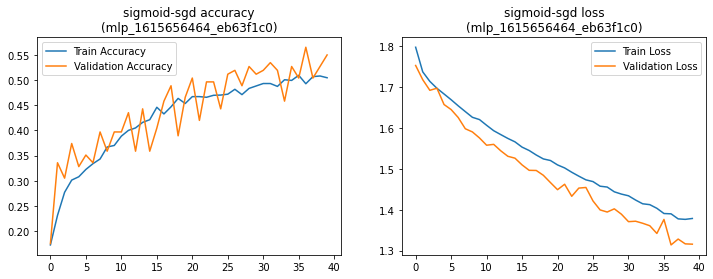

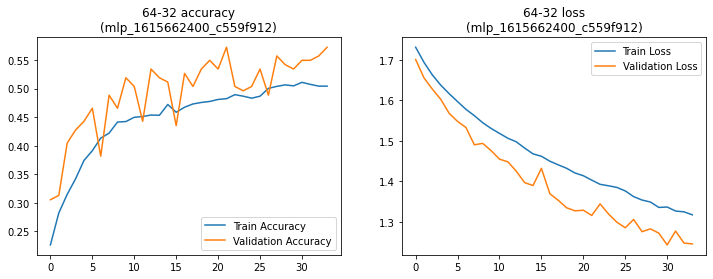

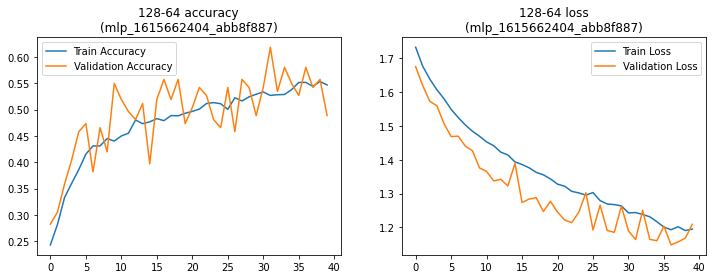

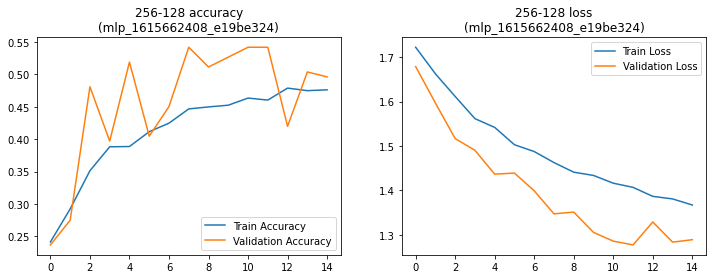

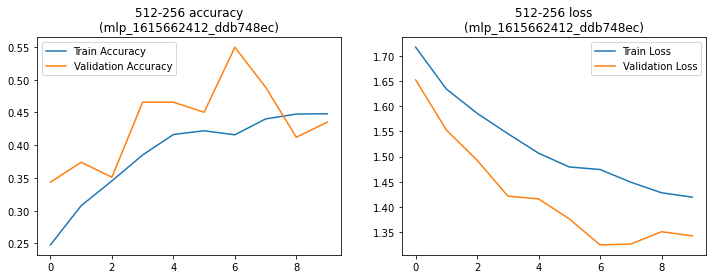

In [251]:
visualize_log(log.loc[[r.id for r in runs2]])

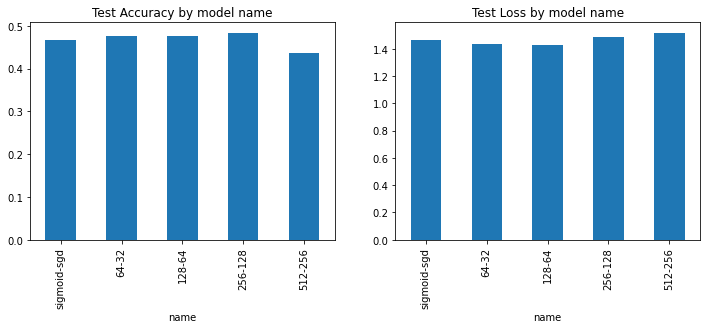

In [254]:
plot_accuracy(log.loc[[r.id for r in runs2]])

# comments

128-64 has the lowest test loss, and 256-128 has the highest test accuracy.  Lets try adding a layer to each of those.

In [54]:
# start with the runs we want to compare to
runs3 = [runs2[2], runs2[3]]

# double check that we got the right runs
for run in runs3:
    print(run.properties['name'])

128-64
256-128


### Model 9

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 128 nodes, sigmoid activation function
- hidden layer 2: 64 nodes, sigmoid activation function
- hidden layer 2: 32 nodes, sigmoid activation function
- optimizer: sgd

In [55]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '128,64,32',
        '--activation', 'sigmoid,sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [56]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': '128-64-32'})

runs3[-1].tag('activation', 'sigmoid')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '2')
runs3[-1].tag('layer sizes', '128,64,32')

### Model 10

Since sigmoid and sgd performed best we will keep those but try various sizes for the nodes in the hidden layers.
- hidden layer 1: 256 nodes, sigmoid activation function
- hidden layer 2: 128 nodes, sigmoid activation function
- hidden layer 3: 64 nodes, sigmoid activation function

- optimizer: sgd

In [57]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--nodes', '256,128,64',
        '--activation', 'sigmoid,sigmoid,sigmoid',
        '--optimizer', 'sgd',
        '--epochs', 50]

src = ScriptRunConfig(source_directory='train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [58]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': '256-128-64'})

runs3[-1].tag('activation', 'sigmoid')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '2')
runs3[-1].tag('layer sizes', '256,128,64')

### Start Tensorboard to monitor the runs

In [66]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs3)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [65]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

In [255]:
log = log_runs(runs3, 'mlp')

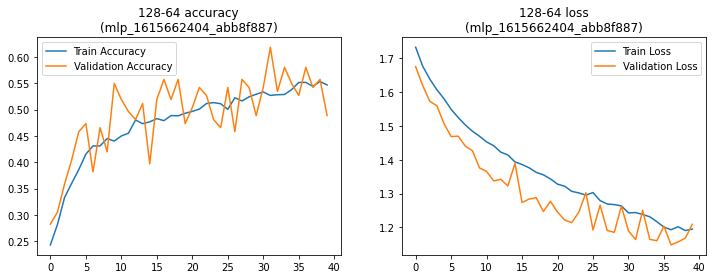

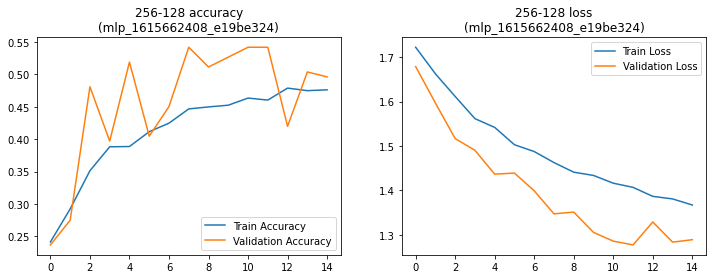

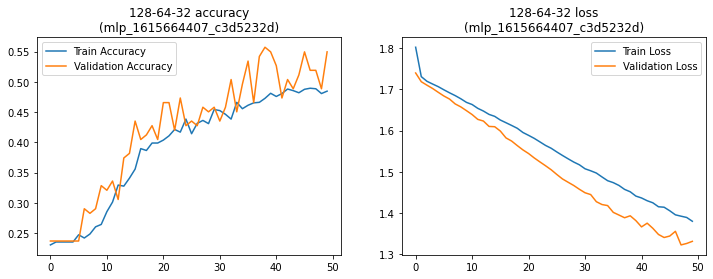

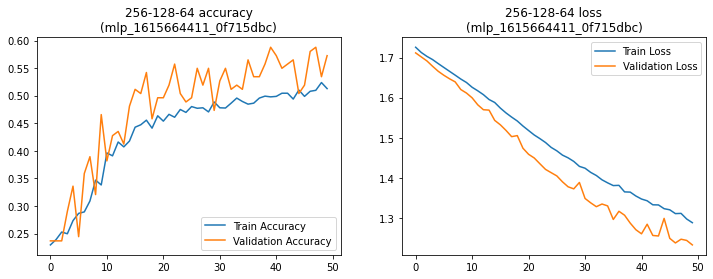

In [256]:
visualize_log(log.loc[[r.id for r in runs3]])

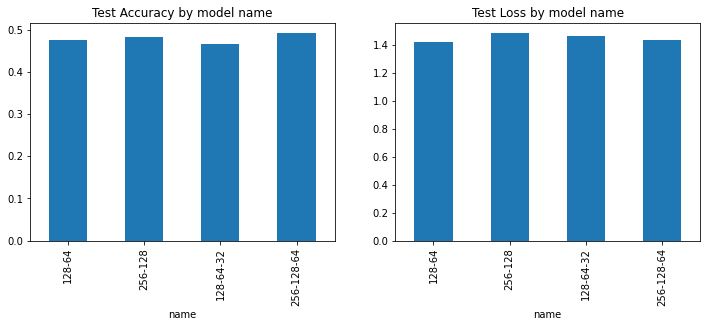

In [258]:
plot_accuracy(log.loc[[r.id for r in runs3]])

Adding a layer to our best model made a small difference but we may have exhausted  the possibilities of multi layer perceptrons.